## Minimal test of XyloSamna and XyloMonitor
- Deploying a dummy network on Xylo a2 and Xylo a3 


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from rockpool.devices.xylo.syns61201 import config_from_specification as a2_config_from, mapper as a2_mapper, XyloSamna as a2_XyloSamna, XyloMonitor as a2_XyloMonitor
from rockpool.devices.xylo.syns65302 import config_from_specification as a3_config_from, mapper as a3_mapper, XyloSamna as a3_XyloSamna, XyloMonitor as a3_XyloMonitor

from rockpool.transform.quantize_methods import channel_quantize
from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

from samna.xyloA3.configuration import InputInterfaceConfig


### Build a Dummy network 

In [3]:
net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),
    Linear((63, 8)),
    LIF(8),
)

### Map it to Xylo a2
- and verify the weights

In [3]:
spec = a2_mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
a2_config, is_valid, msg = a2_config_from(**Q_spec)

if not is_valid:
    print(msg)

Text(0.5, 1.0, 'readout weights')

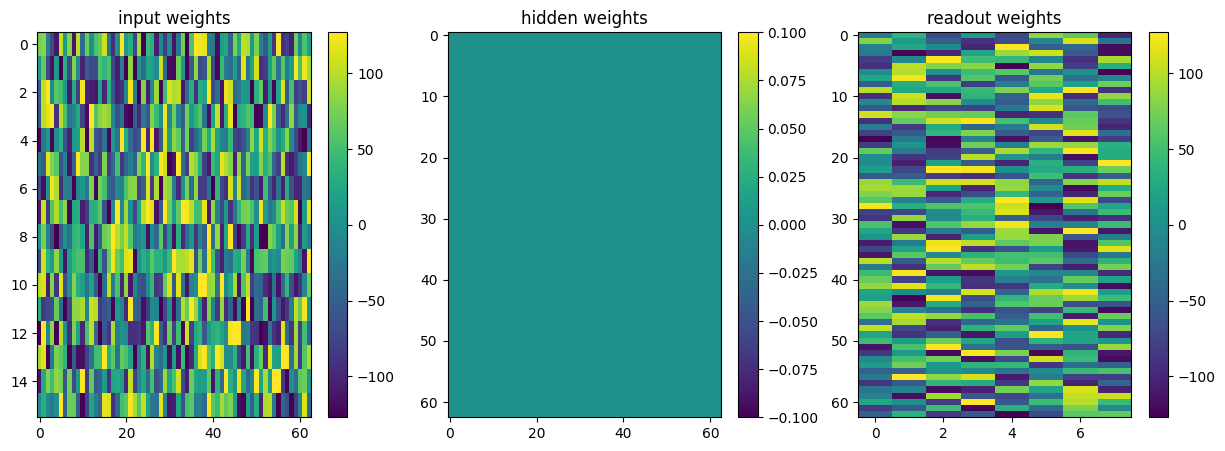

In [4]:
w_in = a2_config.input.weights
w_hid = a2_config.reservoir.weights
w_out = a2_config.readout.weights
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(w_in, aspect='auto'); plt.colorbar(); plt.title('input weights')
plt.subplot(132)
plt.imshow(w_hid, aspect='auto');plt.colorbar(); plt.title('hidden weights')
plt.subplot(133)
plt.imshow(w_out, aspect='auto');plt.colorbar(); plt.title('readout weights')

### Detecting Xylo a2

In [5]:
from rockpool.devices.xylo import find_xylo_hdks
xylo_hdks, xylo_support_modules, xylo_versions = find_xylo_hdks()
print(xylo_hdks, xylo_support_modules, xylo_versions)
xa2_node = xylo_hdks[0]

The connected Xylo HDK contains a Xylo Audio v2 (SYNS61201). Importing `rockpool.devices.xylo.syns61201`
[<samna.xyloA2TestBoard.XyloA2TestBoard object at 0x7f59fd1e4e30>] [<module 'rockpool.devices.xylo.syns61201' from '/home/mina/tools/rockpool/rockpool/devices/xylo/syns61201/__init__.py'>] ['syns61201']


### Create a simple spiking input 


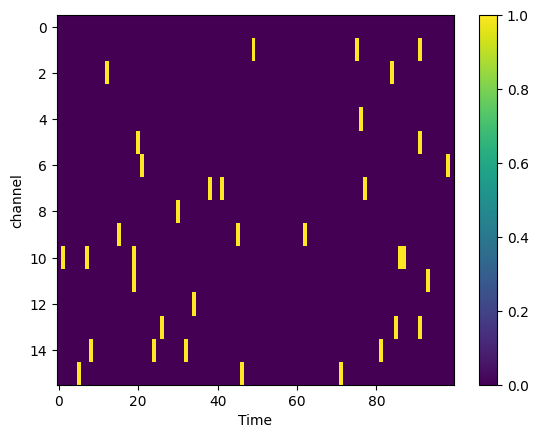

In [4]:
import matplotlib.pyplot as plt
T = 100  #number of time steps
dt = 0.01 #size of time step
Nin = 16 # number of input channels 
p = 0.02 # spiking probablility
input_data = np.random.rand(T,Nin) > (1-p)

plt.figure()
plt.imshow(input_data.T, aspect='auto'); plt.xlabel('Time'); plt.ylabel('channel'); plt.colorbar()

### Testing Xylo a2
- #### with XyloSamna 

[2024-04-12 16:03:04.669] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-12 16:03:04.670] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-12 16:03:04.671] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-12 16:03:05.307] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.


dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out', 'times'])


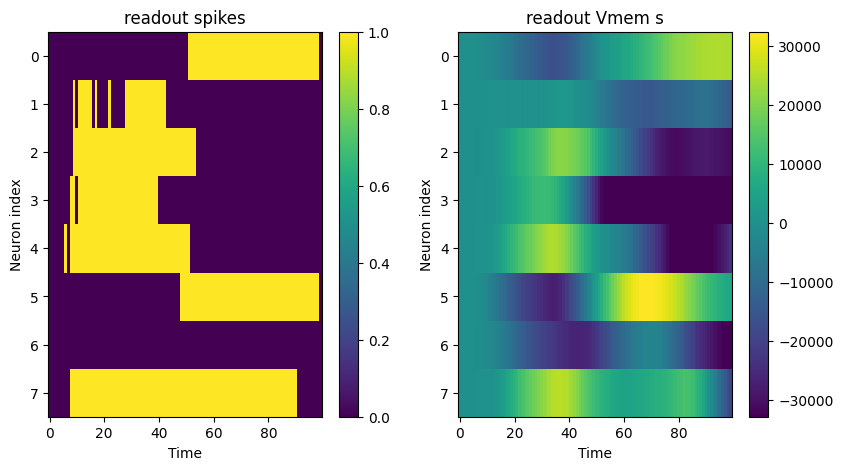

In [7]:
dt = 0.01
Xmod = a2_XyloSamna(xa2_node, a2_config, dt = dt)
out, _, rec = Xmod.evolve(input_data, record = True)
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(out.T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()
plt.subplot(132), plt.imshow(rec['Vmem_out'].T, aspect='auto', interpolation='none');  plt.title('readout Vmem s'); plt.xlabel('Time'); plt.ylabel('Neuron index');  plt.colorbar()
print(rec.keys())

- #### With XyloMonitor
- clapping for 3 seconds

300


[2024-04-12 16:03:09.351] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-12 16:03:09.351] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-12 16:03:09.352] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-12 16:03:09.359] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.


Configuring AFE...
Configured AFE


[2024-04-12 16:03:54.743] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-12 16:03:56.175] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.


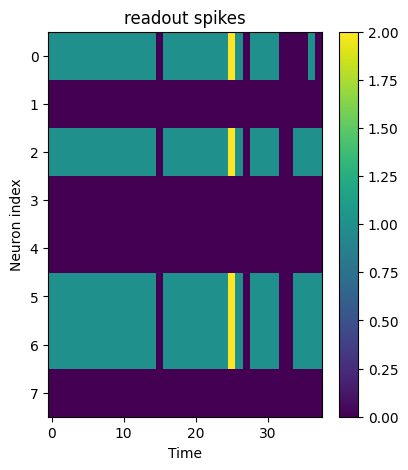

In [8]:

N = 3 # in seconds 
duration = int(N * (1/dt)) 
print(duration)

a2_Monitor = a2_XyloMonitor(xa2_node, a2_config, dt = dt)
out, _, rec = a2_Monitor.evolve(np.zeros((duration , Nin)))
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()


#### Detecting Xylo a3

In [7]:
from rockpool.devices.xylo import find_xylo_hdks
xylo_hdks, xylo_support_modules, xylo_versions = find_xylo_hdks()
print(xylo_hdks, xylo_support_modules, xylo_versions)
xa3_node = xylo_hdks[0]

The connected Xylo HDK contains a Xylo A3. Importing `rockpool.devices.xylo.syns65302`
[<samna.xyloAudio3Boards.XyloAudio3TestBoard object at 0x7f8c0c80ee30>] [<module 'rockpool.devices.xylo.syns65302' from '/home/mina/tools/rockpool/rockpool/devices/xylo/syns65302/__init__.py'>] ['syns65302']


### Testing with XyloSamna for Xylo a3

### Map it to Xylo a3
- and verifying the weights

In [8]:
spec = a3_mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
a3_config, is_valid, msg = a3_config_from(**Q_spec)

if not is_valid:
    print(msg)

Text(0.5, 1.0, 'readout weights')

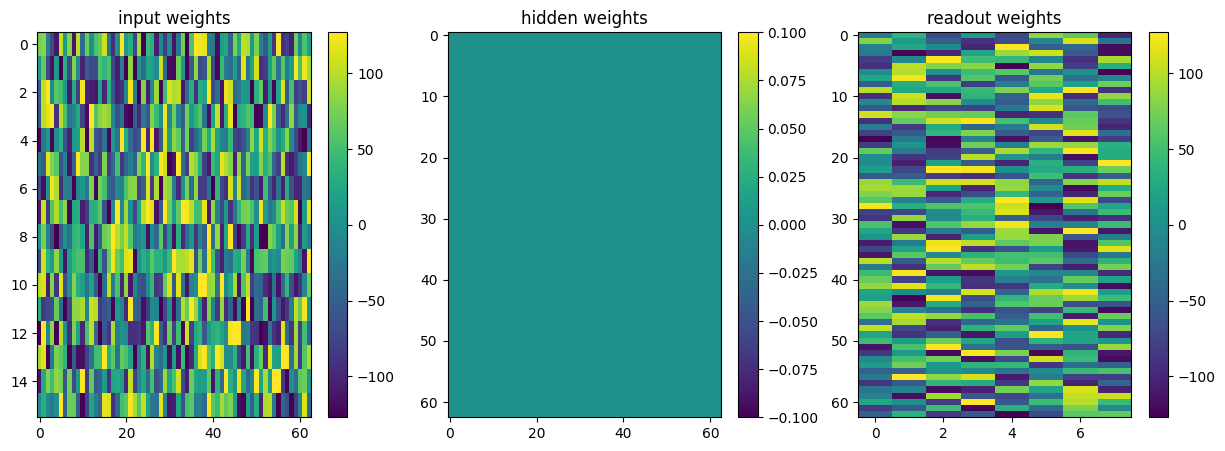

In [13]:
w_in = a3_config.input.weights
w_hid = a3_config.hidden.weights
w_out = a3_config.readout.weights
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(w_in, aspect='auto'); plt.colorbar(); plt.title('input weights')
plt.subplot(132)
plt.imshow(w_hid, aspect='auto');plt.colorbar(); plt.title('hidden weights')
plt.subplot(133)
plt.imshow(w_out, aspect='auto');plt.colorbar(); plt.title('readout weights')

In [9]:
dt = 0.01
Xmod = a3_XyloSamna(xa3_node, a3_config, dt = dt)
out, _, rec = Xmod.evolve(input_data, record = True)

100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


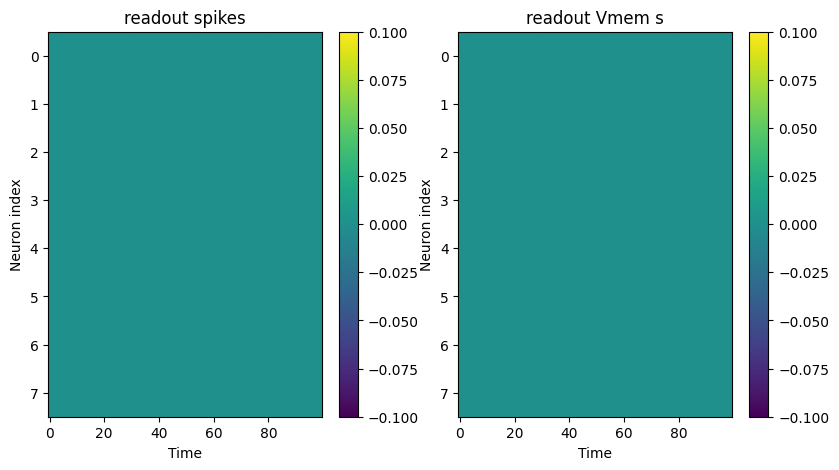

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(out.T, aspect='auto'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()
plt.subplot(132), plt.imshow(rec['Vmem_out'].T, aspect='auto');  plt.title('readout Vmem s'); plt.xlabel('Time'); plt.ylabel('Neuron index');  plt.colorbar()
